Main objective is to fine tune the llm model to handle extra data inside the input provided by the application. <br> 1. Take a question answering dataset. <br> 2. Convert question-answers into triplets. <br> 3. Fine tune llm on the questions with also providing the correct triplets. <br>
Good example for dataset: Databricks-dolly-15k https://huggingface.co/datasets/databricks/databricks-dolly-15k?row=6 <br>

In [ ]:
!nvidia-smi

Fri Apr  5 15:48:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!pip3 install -q -U datasets > /dev/null
!pip3 install -q -U transformers > /dev/null
!pip3 install -q -U accelerate > /dev/null
!pip3 install -q -U bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.4 MB/s eta 0:00:00


In [1]:
import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [2]:
import re
import random
import requests
import tqdm
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModel, pipeline

### Load model

In [32]:
#triplet_extractor = pipeline('text2text-generation', model='Babelscape/rebel-large', tokenizer='Babelscape/rebel-large', device_map={"":0})
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

def transform_text_to_string_of_triplets(text):
  return conc_list_of_triplets(text_to_graph(text))

def text_to_graph(text, model_name="nlg"):
  if model_name=="rebel":
    extracted_text = triplet_extractor.tokenizer.batch_decode([triplet_extractor(text, return_tensors=True, return_text=False)[0]["generated_token_ids"]])
    extracted_triplets = extract_triplets(extracted_text[0])
    return extracted_triplets
  else:
    #batched
    # text: list[string]
    batch_result = []
    texts = batch_inference(text, model, tokenizer)
    for text in texts:
      triplets = nlg_extract_triplet(text)
      if len(triplets) < 1:
        batch_result.append([])
        continue
      triplets = [(t[0].strip(), t[1].strip().lower(), t[2].strip()) for t in triplets]
      triplets = list(set(triplets))
      triplets = sorted(triplets, key=lambda x:x[2])
      triplets = sorted(triplets, key=lambda x:x[1])
      triplets = sorted(triplets, key=lambda x:x[0])
      triplets = [{'head': t[0], 'type': t[1],'tail': t[2]} for t in triplets]
      batch_result.append(triplets)
    return batch_result

def conc_list_of_triplets(extracted_triplets):
  return "\n".join([f"{trip['head']}|{trip['type']}|{trip['tail']}" for trip in extracted_triplets])

def nlg_extract_triplet(text):
  pattern = r"<entry><head>([^<]+)<rel>([^<]+)<tail>([^<]+)"
  matches = re.findall(pattern, text)
  return matches

def inference(text, model, tokenizer):
  template = "### Text: {}\n ### Relations: ".format(text)
  encoded = encodeds = tokenizer(template, return_tensors="pt", add_special_tokens=True)
  model_inputs = encodeds.to("cuda:0")
  generated_ids = model.generate(**model_inputs, max_new_tokens=300, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=False)
  return decoded.split("### Relations: ")[1]

def batch_inference(batched_texts, model, tokenizer):
    templates = [f"### Text: {text}\n ### Relations: " for text in batched_texts]
    encodeds = tokenizer(templates, return_tensors="pt", padding=True, add_special_tokens=True)
    model_inputs = encodeds.to("cuda:0")

    # Generate tokens in batch
    generated_ids = model.generate(**model_inputs, max_new_tokens=300, do_sample=True, pad_token_id=tokenizer.eos_token_id)
    # Decode each item in the batch
    decoded_texts = tokenizer.batch_decode(generated_ids)

    # Extract the relations part from each decoded text
    relations = [decoded.split("### Relations: ")[1] if "### Relations: " in decoded else "" for decoded in decoded_texts]

    return relations

In [4]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quent_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained("rPucs/gemma-2b-relextract-webnlg-final", quantization_config=bnb_config, device_map={"":0})

tokenizer = AutoTokenizer.from_pretrained("rPucs/gemma-2b-relextract-webnlg-final",
                                          add_eos_token=True
)

Unused kwargs: ['bnb_4bit_quent_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
text = "Napoleon Bonaparte (born Napoleone di Buonaparte;[1][b] 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French emperor and military commander who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the leader of the French Republic as First Consul from 1799 to 1804, then of the French Empire as Emperor of the French from 1804 until 1814, and briefly again in 1815. His political and cultural legacy endures as a celebrated and controversial leader. He initiated many enduring reforms, but has been criticized for his authoritarian rule. He is considered one of the greatest military commanders in history and his wars and campaigns are still studied at military schools worldwide. However, historians still debate the degree to which he was responsible for the Napoleonic Wars, in which between three and six million people died.[2][3]"
text = inference(text, model, tokenizer)
triplets = nlg_extract_triplet(text)
triplets = []
print(len(triplets))
triplets = [(t[0].strip(), t[1].strip().lower(), t[2].strip()) for t in triplets]
triplets = list(set(triplets))
triplets = sorted(triplets, key=lambda x:x[2])
triplets = sorted(triplets, key=lambda x:x[1])
triplets = sorted(triplets, key=lambda x:x[0])
for t in triplets:
  print(t[0]," -> ", t[1]," -> ", t[2])

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


0


In [ ]:
#out = transform_text_to_string_of_triplets("Napoleon Bonaparte (born Napoleone di Buonaparte;[1][b] 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French emperor and military commander who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the leader of the French Republic as First Consul from 1799 to 1804, then of the French Empire as Emperor of the French from 1804 until 1814, and briefly again in 1815. His political and cultural legacy endures as a celebrated and controversial leader. He initiated many enduring reforms, but has been criticized for his authoritarian rule. He is considered one of the greatest military commanders in history and his wars and campaigns are still studied at military schools worldwide. However, historians still debate the degree to which he was responsible for the Napoleonic Wars, in which between three and six million people died.[2][3]")
#print(out)
# >> Napoleon Bonaparte|date of birth|15 August 1769
# >> Napoleon Bonaparte|date of death|5 May 1821
# >> Napoleon Bonaparte|participant in|French Revolution
# >> Napoleon Bonaparte|conflict|Revolutionary Wars
# >> French Revolution|participant|Napoleon Bonaparte
# >> Revolutionary Wars|participant|Napoleon Bonaparte


In [ ]:
text = ["Andras lives in Budapest, his favourite food is bread.", "Jordan is a country and also a name."]
results = batch_inference(text, model, tokenizer)
print(result)

# Create dataset

In [39]:
dataset = load_dataset("databricks/databricks-dolly-15k")
filtered_dataset = dataset['train'].filter(lambda example: example['category'] in ["closed_qa", "information_extraction", "summarization"])
print(filtered_dataset.num_rows)

4467


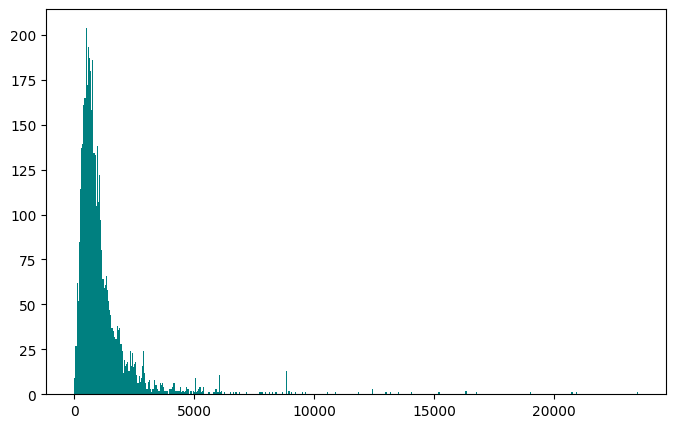

In [40]:
lengths = sorted([len(text) for text in filtered_dataset['context']])

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=500, color='teal')
plt.show()

In [35]:
#batch = 3
#context = []
#test_list = list(range(10))
#for i in range(0, len(test_list), batch):
#  print(i, min(len(test_list), i+batch))

In [41]:
SELECT_N_ROWS = 3000
CONTEXT_CHAR_LIMIT = 3000

print(f"Length before dropping anything: {filtered_dataset.num_rows}")
filtered_dataset = filtered_dataset.filter(lambda x : len(x['context']) < CONTEXT_CHAR_LIMIT)
length = filtered_dataset.num_rows
print(f"New size after dropping too long contextes: {length}")
filtered_dataset = filtered_dataset.select(random.sample(range(length), SELECT_N_ROWS))
print(f"New size after random selection: {filtered_dataset.num_rows}")

#batch
batch = 8
context = []
max_len = len(filtered_dataset)
for i in tqdm.tqdm(range(0, max_len, batch)):
  to = min(max_len, i+batch)
  if i == to:
    continue
  batch_data = filtered_dataset[i:to]
  c = text_to_graph(batch_data["context"])
  context += c


filtered_dataset = filtered_dataset.remove_columns("context")
filtered_dataset = filtered_dataset.add_column("context", context)
#filtered_dataset = filtered_dataset.map(lambda x : {'context': text_to_graph(x['context'])} )

Length before dropping anything: 4467
New size after dropping too long contextes: 4232
New size after random selection: 3000


100%|██████████| 375/375 [3:31:18<00:00, 33.81s/it]


Flattening the indices:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [38]:
idx = 1
print(filtered_dataset[idx]["context"])
print(filtered_dataset[idx]["instruction"])

[{'head': 'Tesla', 'tail': '"Tesla, Inc."', 'type': 'alternativename'}, {'head': 'Tesla', 'tail': 'South_Korea', 'type': 'country'}, {'head': 'Tesla', 'tail': 'United_States', 'type': 'country'}, {'head': 'Tesla', 'tail': 'Marc_Tarpenning', 'type': 'foundedby'}, {'head': 'Tesla', 'tail': 'Martin_Eberhard', 'type': 'foundedby'}, {'head': 'Tesla', 'tail': '2003-07-01', 'type': 'foundingdate'}, {'head': 'Tesla', 'tail': 'Automotive', 'type': 'industry'}, {'head': 'Tesla', 'tail': 'Elon_Musk', 'type': 'keyperson'}, {'head': 'Tesla', 'tail': 'Martin_Eberhard', 'type': 'keyperson'}, {'head': 'Tesla', 'tail': 'Austin,_Texas', 'type': 'location'}, {'head': 'Tesla', 'tail': 'Texas', 'type': 'location'}, {'head': 'Tesla', 'tail': 'Battery_electric_vehicle', 'type': 'product'}, {'head': 'Tesla', 'tail': 'Solar_power', 'type': 'product'}, {'head': 'Tesla', 'tail': 'Tesla_Semi', 'type': 'product'}]
From the passage list down the various models of Tesla vehicle. List the results in comma separated f

In [42]:
filtered_dataset = filtered_dataset.train_test_split(test_size=0.2)
train, test = filtered_dataset["train"], filtered_dataset["test"]
train.push_to_hub("rPucs/TripletDollyQA-3k-Gemma-Nlg", "train",
                          private=False,
                          commit_description="""\
Upload of the progmatically created TripletDollyQA dataset.
Model used: rPucs/gemma-2b-relextract-webnlg-final
""",
                          token=os)
test.push_to_hub("rPucs/TripletDollyQA-3k-Gemma-Nlg", "test",
                          private=False,
                          commit_description="""\
Upload of the progmatically created TripletDollyQA dataset.
Model used: rPucs/gemma-2b-relextract-webnlg-final
""",
                          token=os)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/517 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/rPucs/TripletDollyQA-3k-Gemma-Nlg/commit/eacc39cd0ff057b5e7180bad24294cf763ef1747', commit_message='Upload dataset', commit_description='Upload of the progmatically created TripletDollyQA dataset.\nModel used: rPucs/gemma-2b-relextract-webnlg-final\n', oid='eacc39cd0ff057b5e7180bad24294cf763ef1747', pr_url=None, pr_revision=None, pr_num=None)

In [47]:
test = load_dataset("rPucs/TripletDollyQA-3k-Gemma-Nlg", "test")


In [50]:
test["train"][0]

{'instruction': 'What is the Fallout game?',
 'response': "Fallout is a cyberpunk game based in a post-apocalyptic world. It is an RPG that gained extreme popularity for its storytelling, setting, music and art. The famous RPG game uses a 1950's retro world that is combined with futuristic technology to create a unique setting. With many branching quest lines and plenty of items, weapons and loot, the game has hours worth of content. The basic plot of the game follows a vault dweller. The main character emerges from an underground vault to find a broken but thriving post-apocalyptic world. He meets many different people struggling to survive and monsters that evolved from all the radiation.",
 'category': 'summarization',
 'context': [{'head': 'Fallout:_A_Post-Nuclear_Role-Playing_Game',
   'tail': '"Vault Dweller infiltrates Vault 13, looking for supplies"',
   'type': 'prehistoricdeception'},
  {'head': 'Fallout:_A_Post-Nuclear_Role-Playing_Game',
   'tail': 'World_War_III',
   'type